In [139]:
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import numpy as np
import random

In [140]:
data = load_breast_cancer()
shuffledIndices = np.random.permutation(len(data.target))
data.data, data.target = data.data[shuffledIndices], data.target[shuffledIndices]
train_x, test_x = data.data[:100, 0:2], data.data[100:, 0:2]
train_y, test_y = data.target[:100], data.target[100:]

In [141]:
# 하이퍼파라미터를 조율합니다.
weight = np.random.rand(train_x.shape[1])
learning_rate = 0.0001
iterations = 10000

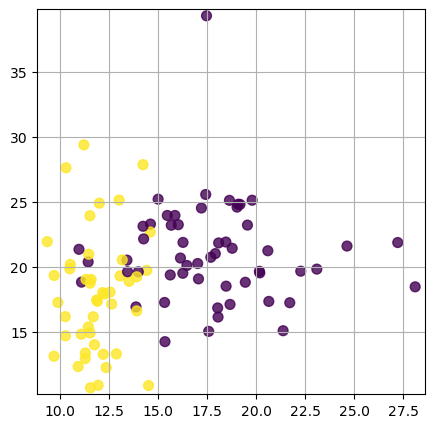

In [142]:
# matplotlib을 통해 해당 자료의 그래프를 그립니다.
plt.figure(figsize=(5,5))
plt.scatter(x=train_x[:, 0], y=train_x[:, 1], s=50, alpha=0.8, c=train_y)
plt.xlim(train_x[:, 0].min() - 0.5, train_x[:, 0].max() + 0.5)
plt.ylim(train_x[:, 1].min() - 0.5, train_x[:, 1].max() + 0.5)
plt.grid()
plt.show()

In [143]:
# 비용함수를 정의합니다.
def cross_entropy(independent, dependent):
    global weight
    probability = np.dot(independent, weight)
    loss = np.mean(np.exp(1 - probability) * dependent) + np.sum(np.exp(probability) * (1 - dependent))
    print(f"cost: {loss:.3f}")

def negative_log_likelihood(independent, dependent):   
    global weight
    probability = np.dot(independent, weight)
    loss = np.mean(np.exp(1 - probability) * dependent) + np.sum(np.exp(probability) * (1 - dependent))
    print(f"cost: {loss:.3f}")

In [144]:
# 최적화가 수행되지 않은 모델을 가지고 비용을 계산해봅니다. 이 값들은 학습 후에는 더 작아져 있어야 합니다.
cross_entropy(test_x, test_y)
negative_log_likelihood(test_x, test_y)

cost: 10344921371.744
cost: 10344921371.744


In [145]:
# 활성화 함수를 정의합니다.
sigmoid = lambda x, e=2.7182: 1 / (1 + e**(-x))
reLu = lambda x: np.array([max(0, obj) for obj in x])
seLu = lambda x, e=2.7182, a=1.0507: np.array([obj if obj >= 0 else a * (e**obj - 1) for obj in x])
actDict = {"sigmoid":sigmoid,"reLu":reLu,"seLu":seLu}

In [146]:
# 경사 하강법을 연산하는 함수를 정의합니다.
def gradient_descent_rule(independent, dependent, function, lr):
    global weight
    indications = actDict[function](np.dot(independent, weight))
    weight -= (lr / independent.shape[0]) * np.dot(independent.T, (indications - dependent))

In [147]:
# 학습을 진행합니다.
for epoch in range(iterations):
    gradient_descent_rule(train_x, train_y, "sigmoid", learning_rate)

In [148]:
# 예측을 연산하는 함수를 정의합니다.
def predict(case):
    global weight
    if type(case) == list: case = np.array(case)
    return 1 if np.dot(case, weight) >= 0.5 else 0

In [149]:
# 학습된 모델과 하나의 검사 자료를 가지고 예측값을 연산합니다.
index = random.randrange(len(test_y))
prediction = predict(test_x[index, :])
print(f"pred: {prediction}, actual target: {test_y[index]}")

pred: 0, actual target: 0


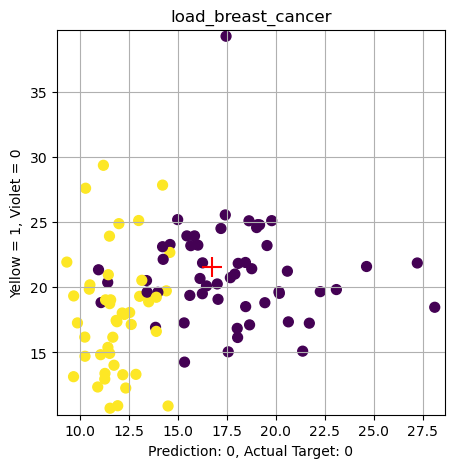

In [150]:
# 학습된 모델과 검사 자료를 가지고 만든 예측값로 그래프를 그립니다.
plt.figure(figsize=(5,5))
plt.scatter(x=train_x[:, 0], y=train_x[:, 1], s=50, alpha=1, c=train_y)
plt.scatter(x=test_x[index,0], y=test_x[index,1], c='r', s=200, marker='+')
plt.xlim(train_x[:, 0].min() - 0.5, train_x[:, 0].max() + 0.5)
plt.ylim(train_x[:, 1].min() - 0.5, train_x[:, 1].max() + 0.5)
plt.grid()
plt.xlabel(f"Prediction: {prediction:.0f}, Actual Target: {test_y[index]}")
plt.ylabel("Yellow = 1, Violet = 0")
plt.title("load_breast_cancer")
plt.show()

In [151]:
# 비용값을 계산합니다. 앞서서 훈련되기 전의 값들보다 작아져있음을 확인할 수 있습니다. 이는 모델이 학습을 통해 적절히 최적화되었음을 의미합니다.
cross_entropy(test_x, test_y)
negative_log_likelihood(test_x, test_y)

cost: 100.206
cost: 100.206
